<a href="https://colab.research.google.com/github/SantoshKumar89/PredictBackup/blob/main/Low_NIFTY_50_MultivarLinearReg3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step #1 Load the Data

In [21]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [22]:
!pip install keras-tuner -q

In [23]:
# Time Series Forecasting - Multivariate Time Series Models for Stock Market Prediction
# A tutorial for this file is available at www.relataly.com

import math # Mathematical functions
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data
import seaborn as sns # Visualization
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# check the tensorflow version and the number of available GPUs
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

# Setting the timeframe for the data extraction
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2020-01-01'

# Getting NASDAQ quotes
# stockname = 'NASDAQ'
# symbol = '^IXIC'

stockname = 'NIFTY 50'
symbol = '^NSEI'

# You can either use webreader or yfinance to load the data from yahoo finance
# import pandas_datareader as webreader
# df = webreader.DataReader(symbol, start=start_date, end=end_date, data_source="yahoo")

import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
df = yf.download(symbol, start=start_date, end=end_date)

# Create a quick overview of the dataset
df.head()

Tensorflow Version: 2.15.0
Num GPUs: 1


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,12202.150391,12222.200195,12165.299805,12182.500000,12182.500000,304100
2020-01-02,12198.549805,12289.900391,12195.250000,12282.200195,12282.200195,407700
2020-01-03,12261.099609,12265.599609,12191.349609,12226.650391,12226.650391,428800
2020-01-06,12170.599609,12179.099609,11974.200195,11993.049805,11993.049805,396500
2020-01-07,12079.099609,12152.150391,12005.349609,12052.950195,12052.950195,447800


# Step #2 Exploring the Data

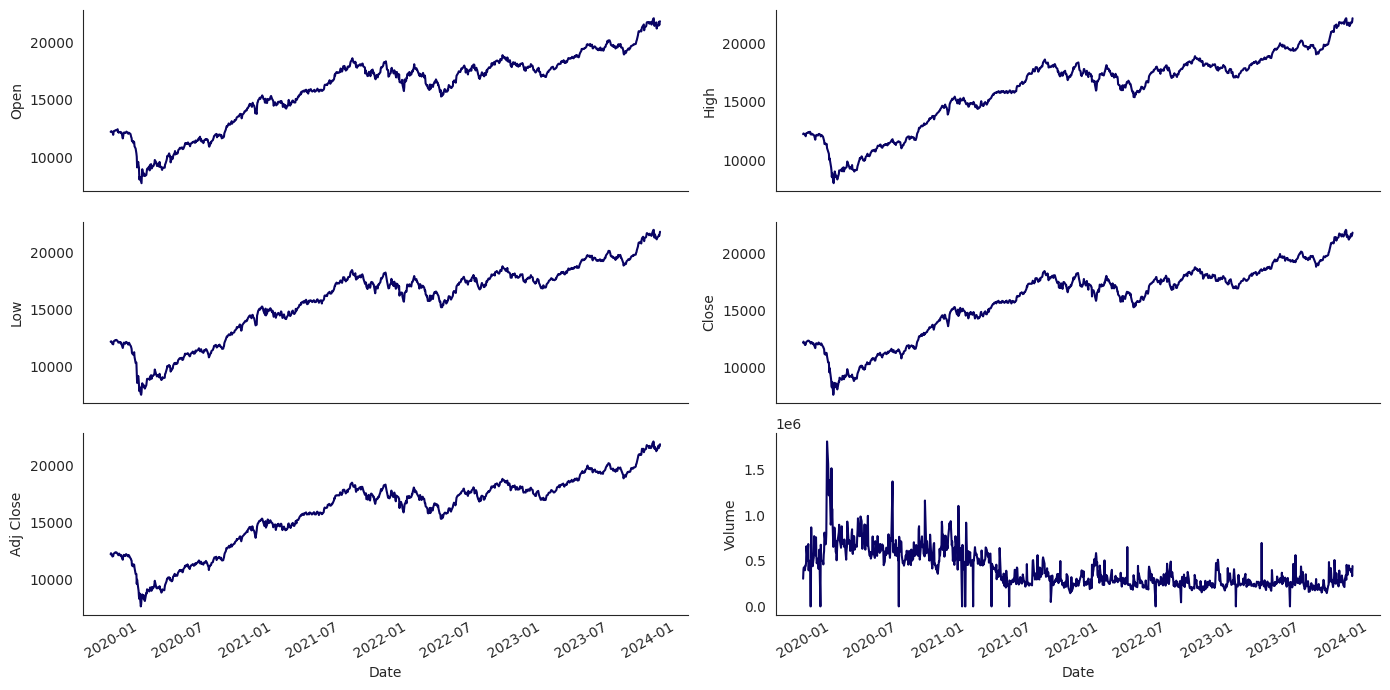

In [24]:
# Plot line charts
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

# Step #3 Preprocessing and Feature Selection

In [25]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
            #, 'Month', 'Year', 'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Low']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2024-01-29,21763.250000,21429.599609,21433.099609,21737.599609,376700,21429.599609
2024-01-30,21813.050781,21501.800781,21775.750000,21522.099609,375100,21501.800781
2024-01-31,21741.349609,21448.849609,21487.250000,21725.699219,410600,21448.849609
2024-02-01,21832.949219,21658.750000,21780.650391,21697.449219,332500,21658.750000
2024-02-02,22126.800781,21805.550781,21812.750000,21853.800781,442800,21805.550781


In [26]:
data_filtered_ext.shape, data_filtered.shape


((1013, 6), (1013, 5))

In [27]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Low'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(1013, 5)


In [28]:
np_data_unscaled.shape,df_Close.shape
df_Close.head()




,Low
Date,
2020-01-01,12165.299805
2020-01-02,12195.250000
2020-01-03,12191.349609
2020-01-06,11974.200195
2020-01-07,12005.349609


In [29]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = data.columns.get_loc("High")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction

    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(761, 50, 5) (761,)
(202, 50, 5) (202,)
0.07220913661719486
0.07220913661719486


In [30]:

data.head

<bound method NDFrame.head of                     Open          High           Low         Close  \
Date                                                                 
2020-01-01  12202.150391  12222.200195  12165.299805  12182.500000   
2020-01-02  12198.549805  12289.900391  12195.250000  12282.200195   
2020-01-03  12261.099609  12265.599609  12191.349609  12226.650391   
2020-01-06  12170.599609  12179.099609  11974.200195  11993.049805   
2020-01-07  12079.099609  12152.150391  12005.349609  12052.950195   
...                  ...           ...           ...           ...   
2024-01-29  21433.099609  21763.250000  21429.599609  21737.599609   
2024-01-30  21775.750000  21813.050781  21501.800781  21522.099609   
2024-01-31  21487.250000  21741.349609  21448.849609  21725.699219   
2024-02-01  21780.650391  21832.949219  21658.750000  21697.449219   
2024-02-02  21812.750000  22126.800781  21805.550781  21853.800781   

               Adj Close  Volume  
Date                    

In [31]:
len(x_train[0]),len(x_train[0][2]),x_train[0][0],x_train[0][0][0]

(50,
 5,
 array([0.29704006, 0.32189612, 0.31139013, 0.31560621, 0.16791828]),
 0.2970400554976165)

In [32]:
y_train.shape

(761,)

In [33]:
x_train[1][49],x_train[2][49],y_train[0:20]

(array([0.15063681, 0.07220914, 0.0956721 , 0.1618636 , 0.76642739]),
 array([0.1110906 , 0.11439475, 0.12914637, 0.10955536, 0.49569299]),
 array([0.07220914, 0.11439475, 0.09713871, 0.06196613, 0.02223227,
        0.04613832, 0.00501428, 0.        , 0.01408494, 0.05490122,
        0.06997865, 0.0506892 , 0.05857372, 0.0475319 , 0.0376728 ,
        0.05877776, 0.07903893, 0.09637448, 0.09691744, 0.09426846]))

In [34]:
x_train[0][1], x_train[1], len(x_train[1])


(array([0.30184495, 0.32396755, 0.31113914, 0.32248816, 0.22512424]),
 array([[3.01844946e-01, 3.23967555e-01, 3.11139141e-01, 3.22488158e-01,
         2.25124241e-01],
        [3.00120245e-01, 3.23697794e-01, 3.15499425e-01, 3.18653752e-01,
         2.36775262e-01],
        [2.93981074e-01, 3.08679196e-01, 3.09190761e-01, 3.02529132e-01,
         2.18939812e-01],
        [2.92068406e-01, 3.10833567e-01, 3.02812387e-01, 3.06663844e-01,
         2.47266703e-01],
        [2.84460078e-01, 3.05594507e-01, 2.93053127e-01, 3.04758673e-01,
         2.46272777e-01],
        [2.97171328e-01, 3.19631052e-01, 3.07974393e-01, 3.17911718e-01,
         2.63666483e-01],
        [3.03356659e-01, 3.25209035e-01, 3.16189571e-01, 3.20734859e-01,
         3.64770845e-01],
        [3.05240980e-01, 3.30230206e-01, 3.17981106e-01, 3.25756534e-01,
         2.76642739e-01],
        [3.07831497e-01, 3.31814055e-01, 3.20518473e-01, 3.28017150e-01,
         3.40309221e-01],
        [3.06475939e-01, 3.29742624e-01

# Step #4 Model Training

In [35]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
#model.add(Dropout(0.1)) # new added
#model.add(LSTM(n_neurons, return_sequences=True))# new added
#model.add(LSTM(n_neurons, return_sequences=True))# new added
#model.add(Dropout(0.1))# new added
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

250 50 5


In [36]:
# Training the model
epochs = 60
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                   )

                    #callbacks=[early_stop])

Epoch 1/60
48/48 [==============================] - 5s 29ms/step - loss: 0.0182 - val_loss: 0.0014
Epoch 2/60
48/48 [==============================] - 0s 10ms/step - loss: 5.9560e-04 - val_loss: 0.0010
Epoch 3/60
48/48 [==============================] - 0s 10ms/step - loss: 5.4461e-04 - val_loss: 8.7884e-04
Epoch 4/60
48/48 [==============================] - 0s 10ms/step - loss: 5.1566e-04 - val_loss: 0.0012
Epoch 5/60
48/48 [==============================] - 1s 13ms/step - loss: 5.2027e-04 - val_loss: 5.5286e-04
Epoch 6/60
48/48 [==============================] - 1s 20ms/step - loss: 5.4548e-04 - val_loss: 0.0029
Epoch 7/60
48/48 [==============================] - 1s 21ms/step - loss: 5.0974e-04 - val_loss: 3.2338e-04
Epoch 8/60
48/48 [==============================] - 1s 27ms/step - loss: 4.6598e-04 - val_loss: 0.0012
Epoch 9/60
48/48 [==============================] - 1s 18ms/step - loss: 4.8268e-04 - val_loss: 4.7988e-04
Epoch 10/60
48/48 [==============================] - 1s 17ms/

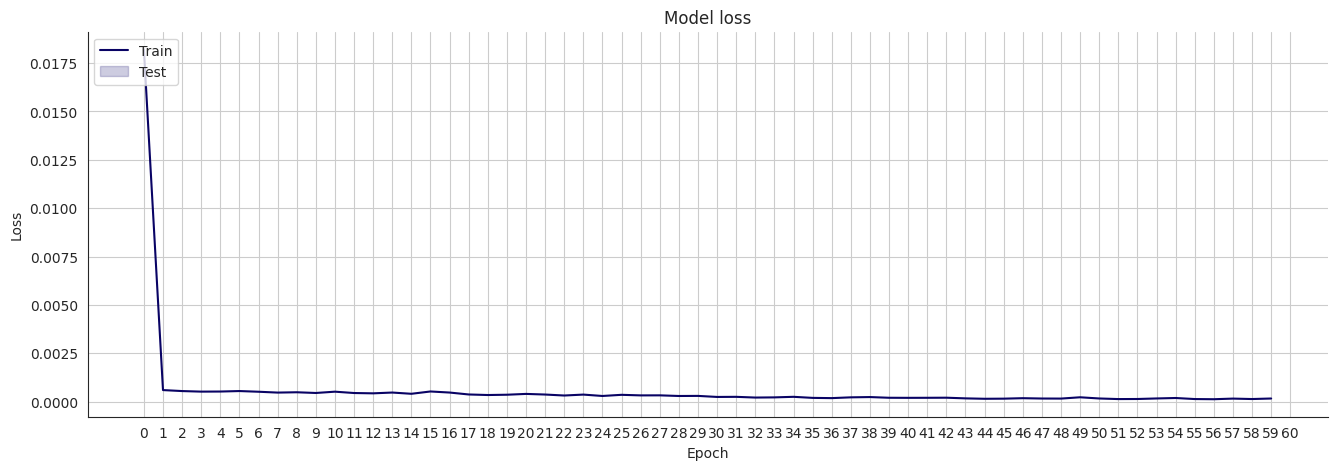

In [37]:
from matplotlib.ticker import FixedLocator

# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
#ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
# Set ticks at every epoch
ax.xaxis.set_major_locator(FixedLocator(range(epochs + 1)))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

# Step #5 Evaluate Model Performance

In [38]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

7/7 [==============================] - 1s 6ms/step
Median Absolute Error (MAE): 133.76
Mean Absolute Percentage Error (MAPE): 0.68 %
Median Absolute Percentage Error (MDAPE): 0.63 %


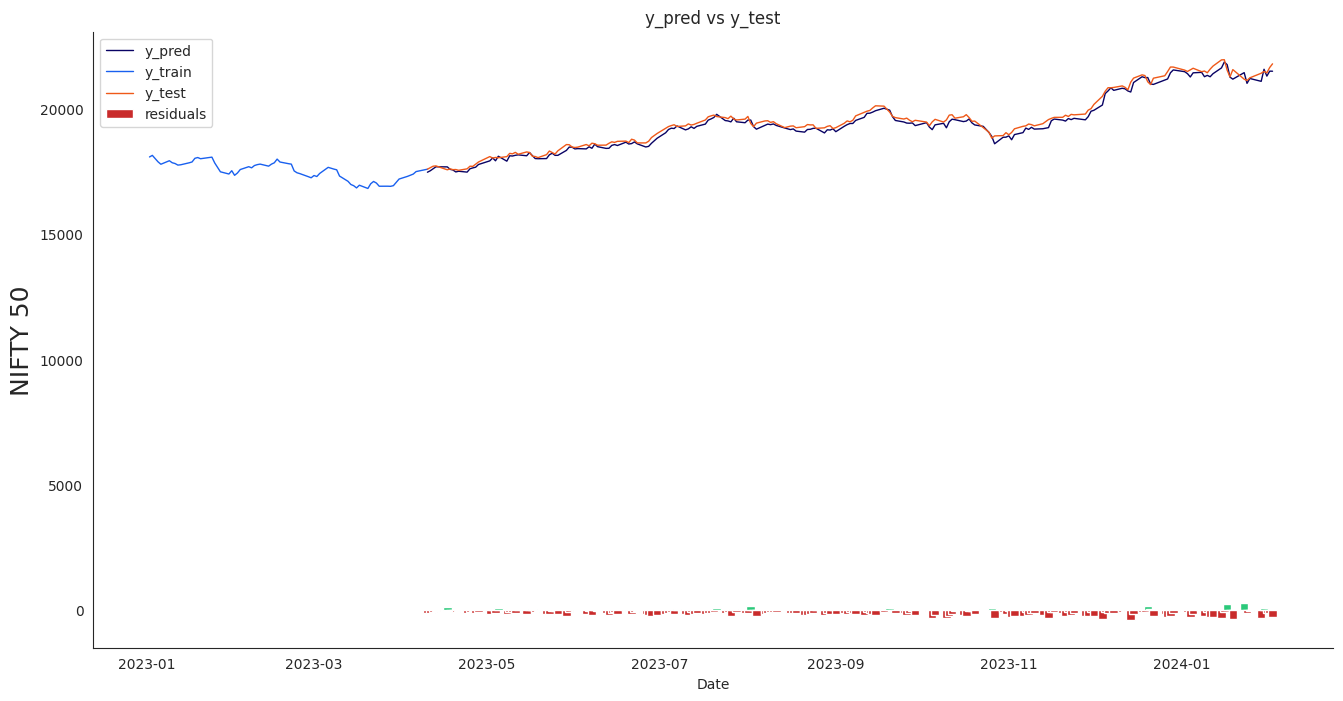

In [39]:
# The date from which on the date is displayed
display_start_date = "2023-01-01"

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext['Low'][:train_data_len + 1]).rename(columns={'Low': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Low'][train_data_len:]).rename(columns={'Low': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

# Step #6 Predict Next Day's Price

In [40]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Low'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The low price for {stockname} at {end_date} was {price_today}')
print(f'The predicted low price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 18ms/step
The low price for NIFTY 50 at 2024-02-03 was 21805.55
The predicted low price is 21777.369140625 (-0.13%)
